# Experiment Notebook 
#### This notebook is meant to experiment with different parameters, architectures, and normalization methods associated with the gRNA2knockdown Library.
#### The basic characteristic of the model as developed by Enoch Yeung are still preserved in the __main__ function of the module.

In [1]:
import os
import csv
import numpy as np
import platereadertools as prt
import gRNA2knockdown as g2k 

import matplotlib.pyplot as plt 
import tensorflow as tf

2024-03-02 13:28:58.424037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### First Let's import or data, the description of which is below:
- The sequencing data is imported as a CSV and contains gRNA designs which tile the target (GFP) with 3bp of overlap.
- The time series data is imported as a TSV text file generated BioTek's Gen5 software and from data collected on Synergy H1s.
- The experimental design is:
  - Total run time = 18 hours
  - Time step = 3 min.
  - Reads:
    - OD600: Absorbance at 600 nm
    - Fluorescence: Excitation = 480 nm, Emission = 510 nm.
  - Runs where conducted with breath-easy film to reduce moisture loss.

In [2]:
# First we need to load the data
data_fp = "Data/"
spacer_fp = os.path.join(data_fp, "GFP_spacers.gbk")
data_0nM_fp = os.path.join(data_fp,
                            "p2x11_80memberlibrary_0mMIPTG20230730.txt")
data_10mM_fp = os.path.join(data_fp,
                            "p2x11_80memberlib_10mMIPTG20230730.txt")

# Organize the label, sequence data from platereadertools and the csv standard module.
seqs = csv.reader(open("Data/GFP_spacers.csv"))
allseqs = [seq for seq in seqs]
data0, time0 = prt.Organize(data_0nM_fp, 8, 12, 18, 3/60)
data1, time1 = prt.Organize(data_10mM_fp, 8, 12, 18, 3/60)

# Based off of the timeseries data, we can see that the greatest change in flourescence occurs at timepoint 165 
# (~8hours). We will use this timepoint to calculate the fold change between the 0mM and 10mM data.
reads = list(data0.keys())
data_pt0 = data0[reads[1]][:,:,165]
data_pt1 = data1[reads[1]][:,:,165]

# Calculate the fold change between the 0mM and 10mM data.
fold_change = data_pt1/data_pt0
data = np.reshape(fold_change,(96))

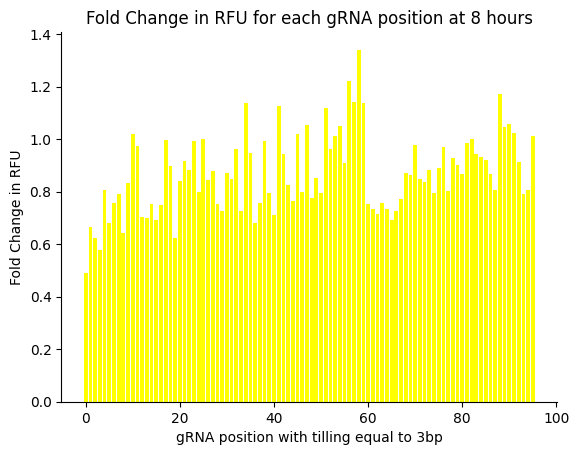

In [3]:
fig, ax = plt.subplots(1,1)
ax.bar(range(len(data)), data, color = 'yellow')
ax.set_xlabel("gRNA position with tilling equal to 3bp")
ax.set_ylabel('Fold Change in RFU')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Fold Change in RFU for each gRNA position at 8 hours")
if True:
    plt.savefig("./Figures/foldchange.png")

### Define the gRNA2knockdown model parameters.
- The size of the gRNAs is 30 bp, so it makes may make sense to make the intermediate layers 30 nodes.
- For now lets keep the embedding space the same size, and not try to use the resnet functionality.

In [4]:
stride_parameter = 29
label_dim = 1
embedding_dim = 4
intermediate_dim = 15
batch_size_parameter=80 # Should be the same as the number of gRNAs
debug_splash = 0
this_step_size_val = 1
this_corpus, this_labels = g2k.make_labeled_corpus(allseqs, data, stride_parameter)
sess = None

In [5]:
# Define the random transformation householder matrix.
Rand_Transform = g2k.rvs(dim=stride_parameter)

# Define the corpus for the model.
this_corpus_vec = []
for this_corpus_elem in this_corpus:
    vec_value = g2k.sequence_encoding(this_corpus_elem)
    vec_value = np.dot(Rand_Transform,vec_value)
    this_corpus_vec.append(vec_value)

this_corpus_vec = np.asarray(this_corpus_vec)
this_labels = np.expand_dims(this_labels,axis=1)
hidden_vars_list = [stride_parameter, embedding_dim, stride_parameter]
print(hidden_vars_list)

[29, 4, 29]


In [6]:
2784/96

29.0

### Build the model.

In [7]:
# Define the tensorflow session
if sess != None:
        sess.close()
sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution() # needed because of placeholder variables

this_u = tf.compat.v1.placeholder(tf.float32, 
                                    shape=[None,stride_parameter])

with tf.device('/cpu:0'):
    this_W_list,this_b_list = g2k.initialize_Wblist(stride_parameter,
                                                hidden_vars_list)
    this_y_out,all_layers = g2k.network_assemble(this_u,this_W_list,this_b_list
                                            ,keep_prob=1.0,
                                            activation_flag=2,res_net=0)

this_embedding = all_layers[-2]
regress_list = [intermediate_dim]*1+[label_dim]
with tf.device('/cpu:0'):
    this_Wregress_list,this_bregress_list = g2k.initialize_Wblist(embedding_dim,regress_list)


Length of hv_list: 3
shape: 
shape: 
shape: 
n_depth: 3
Length of hv_list: 2
shape: 
shape: 


In [8]:

HybridLoss = g2k.customLoss(this_y_out,this_u,this_embedding)
this_optim = tf.compat.v1.train.AdagradOptimizer(
    learning_rate=this_step_size_val).minimize(HybridLoss)
step_size = tf.compat.v1.placeholder(tf.float32,shape=[])
result = sess.run(tf.compat.v1.global_variables_initializer())
this_vae_loss = g2k.vae_loss(this_y_out,this_u)
this_embed_loss = g2k.embed_loss(this_u,this_embedding)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2024-03-02 13:29:03.286720: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


In [9]:
g2k.train_net(sess, this_corpus_vec, 
              this_u, HybridLoss,
              this_optim,
              batchsize=batch_size_parameter, 
              this_vae_loss=this_vae_loss, 
              this_embed_loss=this_embed_loss,
              step_size_val=this_step_size_val*0.1, 
              valid_error_thres=1e-4,
              test_error_thres=1e-4, max_iters=10e4,
              save_fig='Figures/stepsize0_05.png'
              )

 step 1 , validation error 25.4784
 step 1 , test error 24.9383
 Reconstruction Loss: 5.989125
 Embedding Loss: 19.327744
 step 10 , validation error 1.14309
 step 10 , test error 1.15862
 Reconstruction Loss: 0.445223
 Embedding Loss: 0.6976117
 step 20 , validation error 1.05432
 step 20 , test error 1.05583
 Reconstruction Loss: 0.35485432
 Embedding Loss: 0.6976117
 step 30 , validation error 1.0061
 step 30 , test error 1.01217
 Reconstruction Loss: 0.29899228
 Embedding Loss: 0.6976117
 step 40 , validation error 0.975674
 step 40 , test error 1.00739
 Reconstruction Loss: 0.27568832
 Embedding Loss: 0.6976117
 step 50 , validation error 0.951901
 step 50 , test error 0.992053
 Reconstruction Loss: 0.2607939
 Embedding Loss: 0.6976117
 step 60 , validation error 0.947616
 step 60 , test error 0.962023
 Reconstruction Loss: 0.25143105
 Embedding Loss: 0.6976117
 step 70 , validation error 0.942397
 step 70 , test error 0.94297
 Reconstruction Loss: 0.23815417
 Embedding Loss: 0.69

([[0.8178514,
   0.82555634,
   0.8162025,
   0.8175345,
   0.81807745,
   0.8201152,
   0.8167277,
   0.814184,
   0.81683487,
   0.8209516,
   0.81562614,
   0.8144849,
   0.8244396,
   0.8285213,
   0.8180149,
   0.81184596,
   0.8272203,
   0.8295487,
   0.8144506,
   0.8243819],
  [0.81076896,
   0.80262774,
   0.7956142,
   0.8041617,
   0.79908556,
   0.7940375,
   0.79590464,
   0.79958475,
   0.7942437,
   0.7980839,
   0.8054986,
   0.79801965,
   0.8075395,
   0.7947844,
   0.80031246,
   0.799591,
   0.797297,
   0.7990898,
   0.80001056,
   0.8030927],
  [0.84114033,
   0.8326802,
   0.83236295,
   0.82868606,
   0.8352125,
   0.830468,
   0.8321661,
   0.83129925,
   0.83304334,
   0.8336477,
   0.8327043,
   0.83251095,
   0.82083654,
   0.82752174,
   0.8314213,
   0.8268381,
   0.8259362,
   0.82398176,
   0.8370789,
   0.8243392]],
 1)

In [10]:
print(this_y_out.eval(feed_dict={this_u:[this_corpus_vec[2]]}, session=sess))
z_ind = this_y_out.eval(feed_dict={this_u:[this_corpus_vec[2]]}, session=sess)
print(this_corpus_vec)
print(this_corpus)

[[ 0.49214584 -0.522242   -0.21221739  0.15627557 -0.333225   -0.98788065
  -0.5186566  -0.35403323  0.64127135 -0.90211886 -0.8099184  -0.12927431
  -0.76517916  0.07115391  0.5549704  -1.2176361  -0.00178778 -0.47280252
   0.16409642 -0.6538824  -0.6310512   0.13545597  0.10930264  1.0950241
  -1.1947947  -0.8640912  -1.1499182   0.5992347   0.2982625 ]]
[[ 0.54846792  0.3105474  -0.35519993 ... -1.73290965  0.30556577
   0.43814497]
 [ 0.12895861 -0.19874625 -0.22840614 ... -1.74711758  0.41464294
   0.02426698]
 [ 0.37772551 -0.24847575  0.29458748 ... -1.39153147  0.62734478
   0.22611245]
 ...
 [ 0.25277383 -0.8461038   0.34786232 ... -1.11651165  0.10201207
   0.60666852]
 [ 0.79308872 -0.70973771 -0.20977923 ... -1.74045142  0.62568683
   0.86822101]
 [ 0.68632377 -0.3674451  -0.39863602 ... -1.75540365  0.82929396
   0.02891828]]
['TTGATCTCCTTTTTAAGTGAACTTGGGCC', 'TGATCTCCTTTTTAAGTGAACTTGGGCCC', 'TTTCATTGTTGATCTCCTTTTTAAGTGAA', 'TTCATTGTTGATCTCCTTTTTAAGTGAAC', 'AAAATTGCTTTCATT

['T', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'C', 'T', 'T', 'T', 'T', 'C', 'T', 'T', 'C', 'T', 'T', 'T'

0.0

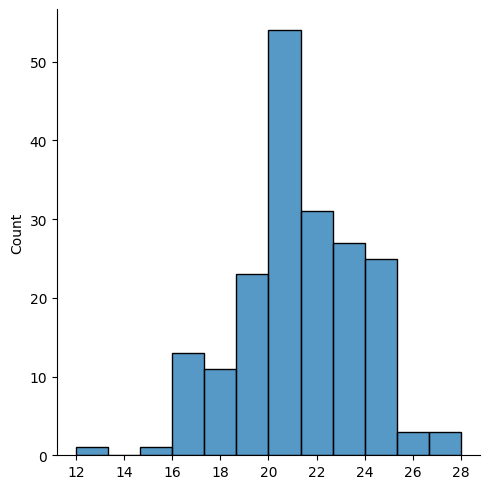

In [11]:
import seaborn as sns;
all_mismatches = []
for ind in range(0,len(this_corpus_vec)):
    z_ind = this_y_out.eval(feed_dict={this_u:[this_corpus_vec[ind]]}, session=sess)
    this_seq_out = g2k.vecback2seq(np.dot(np.linalg.inv(Rand_Transform),z_ind.T))
    print(g2k.vecback2seq(np.dot(np.linalg.inv(Rand_Transform),z_ind.T)))
    this_seq_out = ''.join(this_seq_out)
    all_mismatches.append(g2k.num_mismatch(this_seq_out,this_corpus[ind]));
hist_data = sns.displot(all_mismatches)
mismatch_process = np.array(all_mismatches);
mismatch_process[mismatch_process<=2.0] = 1.0;
mismatch_process[mismatch_process>2.0] = 0.0;
np.sum(mismatch_process)/(len(mismatch_process)*1.0)